In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from astropy import units as u
from astropy.constants import G
from galpy.potential import NFWPotential, ChandrasekharDynamicalFrictionForce
from galpy.orbit import Orbit

G = G.to(u.kpc/u.Msun*(u.km/u.s)**2).value

This documentation can also be found in [galpy documentation](https://docs.galpy.org/en/latest/reference/potentialfdmdynfric.html).

# Creating a dwarf galaxy dark matter halo potential

In [2]:
M = 1e9 #Msol
rs = 1.57 #kpc
c = 18.4 #concentration parameter

A_NFW = np.log(1 + c) - c/(1+c)

NFWHalo = NFWPotential(amp=M/A_NFW * u.Msun, a=rs*u.kpc)

# Initialize a globular cluster object

In [3]:
MGC = 1e6 #Msol
rhm = 1e-2 #kpc

### Dynamical friction

In [4]:
cdf = ChandrasekharDynamicalFrictionForce(GMs=MGC * u.Msun, rhm=rhm * u.kpc, dens=NFWHalo)

# Initialize the orbit

In [5]:
# initial conditions
R = 0.5
z = 0.
phi = 0. 
Menclosed = NFWHalo.mass(R * u.kpc)
vR = 0.0
vT = np.sqrt(G*Menclosed/R) #km/s
vz = 0. 

o = Orbit([R * u.kpc, vR * u.km/u.s, vT * u.km/u.s, z * u.kpc, vz * u.km/u.s, phi * u.rad])
o_cdf = o() # copy of orbit for dynamical friction
o_fdf = o() # copy of orbit for fuzzy dynamical friction

# Integrate

In [6]:
t = np.linspace(0, 1, 300) * u.Gyr
o.integrate(t, NFWHalo, method='odeint')
o_cdf.integrate(t, NFWHalo + cdf, method='odeint')

# Integrating orbits with Fuzzy Dark Matter (FDM) dynamical friction

# Fuzzy Dark Matter (FDM) Dynamical Friction Force

Implements the fuzzy dark matter (FDM) dynamical friction force.

The force is given by:

$$
\vec{F}_\mathrm{FDM} = -\frac{4\pi\mathcal{G}^2 M_\mathrm{obj}^2 \rho}{v^3} C_\mathrm{FDM}(kr) \vec{v}
$$

where the coefficient $C_\mathrm{FDM}(kr)$ depends on $kr = \frac{m v r}{\hbar}$. There are three regimes for the coefficient, depending on the value of $kr$:

1. **Zero-velocity regime**: for $kr < M_\sigma / 2$, where $M_\sigma = v / \sigma(r)$ is the classical Mach number, the coefficient is given by

$$
C_\mathrm{FDM}(kr) = \mathrm{Cin}(2kr) + \frac{\sin(2kr)}{2kr} - 1
$$

with

$$
\mathrm{Cin}(z) = \int_0^z \frac{1 - \cos(t)}{t} \, \mathrm{d}t
$$

2. **Dispersion regime**: for $kr > 2 M_\sigma$, the coefficient is given by

$$
C_\mathrm{FDM}(kr) = \ln\left(\frac{2kr}{M_\sigma}\right) \left[ \mathrm{erf}(X) - \frac{2X}{\sqrt{\pi}} \exp(-X^2) \right]
$$

where $X = \frac{v}{\sqrt{2} \sigma(r)}$.

3. **Intermediate regime**: for $M_\sigma / 2 < kr < 2 M_\sigma$, the coefficient is given by linear interpolation between the zero-velocity and dispersion regimes.

If the FDM coefficient $C_\mathrm{FDM}(kr)$ is larger than the classical coefficient $C_\mathrm{CDM}$, we use the classical coefficient as a cutoff, because it means that we are in the classical regime. The classical coefficient is given by:

$$
C_\mathrm{CDM} = \frac{\ln[ 1+\Lambda^2]}{2} \left[ \mathrm{erf}(X) - \frac{2X}{\sqrt{\pi}} \exp(-X^2) \right]
$$

**See also**

- `ChandrasekharDynamicalFrictionForce`: For the implementation and documentation of the classical Chandrasekhar dynamical friction force (CDM case).

In [7]:
import scipy.special as sp
from galpy.util import conversion
from galpy.potential.ChandrasekharDynamicalFrictionForce import ChandrasekharDynamicalFrictionForce


class FDMDynamicalFrictionForce(ChandrasekharDynamicalFrictionForce):

    def __init__(
        self,
        amp=1.0,
        GMs=0.1,
        gamma=1.0,
        rhm=0.0,
        m=1e-99,  # roughly 1e-22 eV
        dens=None,
        sigmar=None,
        const_lnLambda=False,
        const_FDMfactor=False,
        minr=0.0001,
        maxr=25.0,
        nr=501,
        ro=None,
        vo=None,
    ):
        """
        Initialize a FDM Dynamical Friction force [1]_, [2]_.

        Parameters
        ----------
        amp : float
            Amplitude to be applied to the potential (default: 1).
        GMs : float or Quantity
            Satellite mass; can be a Quantity with units of mass or Gxmass; can be adjusted after initialization by setting obj.GMs= where obj is your ChandrasekharDynamicalFrictionForce instance (note that the mass of the satellite can *not* be changed simply by multiplying the instance by a number, because he mass is not only used as an amplitude).
        rhm : float or Quantity
            Half-mass radius of the satellite (set to zero for a black hole); can be adjusted after initialization by setting obj.rhm= where obj is your ChandrasekharDynamicalFrictionForce instance.
        m : float or Quantity
            Mass of the Fuzzy Dark Matter particle; can be a Quantity with units of eV; default is set to 1e-99, which is roughly 1e-22 eV.
        gamma : float
            Free-parameter in :math:`\\Lambda`.
        dens : Potential instance or list thereof, optional
            Potential instance or list thereof that represents the density [default: LogarithmicHaloPotential(normalize=1.,q=1.)].
        sigmar : callable, optional
            Function that gives the velocity dispersion as a function of r (has to be in natural units!); if None, computed from the dens potential using the spherical Jeans equation (in galpy.df.jeans) assuming zero anisotropy; if set to a lambda function, *the object cannot be pickled* (so set it to a real function).
        const_lnLambda : bool, optional
            If set to a number, use a constant ln(Lambda) instead with this value.
        const_FDMfactor : bool, optional
            If set to a number, use a constant FDM factor instead with this value; if set to False, the FDM factor is calculated from the mass of the Fuzzy Dark Matter particle and the current radius and velocity.
        minr : float or Quantity, optional
            Minimum r at which to apply dynamical friction: at r < minr, friction is set to zero.
        maxr : float or Quantity, optional
            Maximum r for which sigmar gets interpolated; for best performance set this to the maximum r you will consider.
        nr : int, optional
            Number of radii to use in the interpolation of sigmar.
        ro : float or Quantity, optional
            Distance scale for translation into internal units (default from configuration file).
        vo : float or Quantity, optional
            Velocity scale for translation into internal units (default from configuration file).

        Notes
        ----------
        2025-05-30: Started (A. Szpilfidel, P. Boldrini, J. Bovy)

        References
        ----------
        .. [1] Hui et al. (2017), "Ultralight scalars as cosmological dark matter", arXiv:1610.08297 [astro-ph.CO]. https://arxiv.org/abs/1610.08297
        .. [2] Lancaster et al. (2020), "Dynamical friction in fuzzy dark matter", arXiv:1909.06381 [astro-ph.GA]. https://arxiv.org/abs/1909.06381
        """
        ChandrasekharDynamicalFrictionForce.__init__(
            self,
            amp=amp,
            GMs=GMs,
            rhm=rhm,
            dens=dens,
            gamma=gamma,
            sigmar=sigmar,
            const_lnLambda=const_lnLambda,
            minr=minr,
            maxr=maxr,
            nr=nr,
            ro=ro,
            vo=vo,
        )
        self._const_FDMfactor = const_FDMfactor
        self._mhbar = (
            conversion.parse_mass(m, ro=self._ro, vo=self._vo)
            / conversion._GHBARINKM3S3KPC2
            * self._ro**2
            * self._vo**3
        )
        # hasC set in ChandrasekharDynamicalFrictionForce.__init__

    def krValue(self, r, v):
        """
        Evaluate the dimensionless kr parameter kr = mrv / hbar.

        Parameters
        ----------
        r : float
            Spherical radius (natural units).
        v : float
            Current velocity in cylindrical coordinates (natural units).
        Returns
        -------
        kr : float
            Dimensionless kr parameter.
        """
        return self._mhbar * v * r

    def M_sigma(self, r, v):
        """
        Evaluate the classical Mach number M_sigma = v / sigma(r).
        """
        if r > self._maxr:
            sigma = self.sigmar_orig(r)
        else:
            sigma = self.sigmar(r)
        return v / sigma

    def frictionFactor(self, r, vs):
        if r > self._maxr:
            sr = self.sigmar_orig(r)
        else:
            sr = self.sigmar(r)
        X = vs / (np.sqrt(2) * sr)
        Xfactor = sp.erf(X) - 2.0 * X * (1 / np.sqrt(np.pi)) * np.exp(
            -(X**2.0)
        )
        lnLambda = self.lnLambda(r, vs)  # Coulomb logarithm
        kr = self.krValue(r, vs)  # dimensionless kr parameter
        M_sigma = self.M_sigma(r, vs)  # classical Mach number

        # Classical dynamical friction coefficient
        C_cdm = lnLambda * Xfactor

        if kr > 2 * M_sigma:
            # FDM dispersion regime coefficient
            C = np.log(2 * kr / M_sigma) * Xfactor

        elif kr < M_sigma / 2:
            # FDM zero-velocity dynamical friction coefficient
            cosine_integral = (
                -sp.sici(2 * kr)[1] + np.log(2 * kr) + np.euler_gamma
            )
            C = cosine_integral + (np.sin(2 * kr) / (2 * kr)) - 1

        else:
            # intermediate regime between zero-velocity and dispersion regimes
            # recompute FDM zero-velocity regime at kr = M_sigma/2
            cosine_integral = (
                -sp.sici(M_sigma)[1] + np.log(M_sigma) + np.euler_gamma
            )
            C_fdm = cosine_integral + (np.sin(M_sigma) / (M_sigma)) - 1
            C = np.interp(
                kr, [M_sigma / 2, 2 * M_sigma], [C_fdm, np.log(4.0) * Xfactor]
            )

        # If the FDM factor is larger than the classical one, we use the classical one
        if C < C_cdm:
            return C
        else:
            return C_cdm

    def _calc_force(self, R, phi, z, v, t):
        r = np.sqrt(R**2.0 + z**2.0)
        if r < self._minr:
            self._cached_force = 0.0
        else:
            vs = np.sqrt(v[0] ** 2.0 + v[1] ** 2.0 + v[2] ** 2.0)

            if self._const_FDMfactor:
                # Use constant FDM factor
                self._C = self._const_FDMfactor
            else:
                self._C = self.frictionFactor(r, vs)

            self._cached_force = -self._dens(R, z, phi=phi, t=t) / vs**3.0 * self._C

In [8]:
m = 3e-22 # mass of the fuzzy particle in eV
fdf = FDMDynamicalFrictionForce(GMs=MGC * u.Msun, rhm=rhm * u.kpc, dens=NFWHalo, m=m*u.eV)

In [9]:
o_fdf.integrate(t, NFWHalo + fdf, method='odeint')

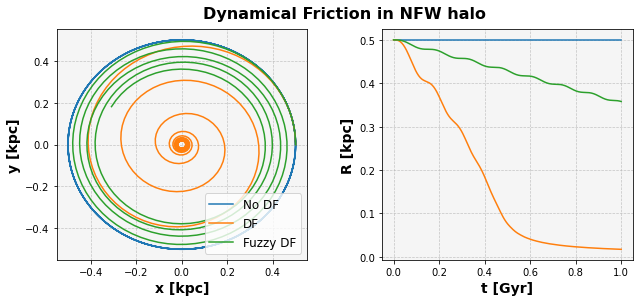

In [11]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(o.x(t), o.y(t), label='No DF')
plt.plot(o_cdf.x(t), o_cdf.y(t), label='DF')
plt.plot(o_fdf.x(t), o_fdf.y(t), label='Fuzzy DF')
plt.xlabel('x [kpc]', fontsize=14, fontweight='bold')
plt.ylabel('y [kpc]', fontsize=14, fontweight='bold')
plt.gca().set_facecolor('whitesmoke')
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
plt.legend(fontsize=12)

plt.subplot(122)
plt.plot(t, o.R(t), label='No DF')
plt.plot(t, o_cdf.R(t), label='DF')
plt.plot(t, o_fdf.R(t), label='Fuzzy DF')
plt.xlabel('t [Gyr]', fontsize=14, fontweight='bold')
plt.ylabel('R [kpc]', fontsize=14, fontweight='bold')
plt.tight_layout(pad=2.5)
plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, wspace=0.3)
plt.gca().set_facecolor('whitesmoke')
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)

plt.suptitle('Dynamical Friction in NFW halo', fontsize=16, fontweight='bold')
plt.show()

We can clearly see that Fuzzy dark matter dynamical friction is weaker than its classical version. 